# Assignment of Capstone Project - The Battle of Neighborhoods (Week 1)

## Introduction (business problem)

Suppose we want to open a Chinese cuisine restaurant, which neighborhood in Downton Toronto is an better location?

Generally speaking, as an private, start-up entrepreneur, the question can be put in an cost-benefit analytics framework, with fundamental rule of profit maximization. Answer to the question depends on the following sub-questions:

1. ***Demand side*** Which neighborhood has the most demands on Chinese cuisine? 
1. ***Supply side*** Which neighborhood so far has the mildest competition regarding Chinese food?
1. ***Market side*** The infrastructure, supply chain, consumer preferences, transportation, neighborhood security, etc.

Lets dive deeper for further analyses, one by one

### Demand side

From the perspective of demand side, customers that may bring profits to restaurant are likely to be composed of two parts, domestic demand and external demand

- ***Domestic demand*** referes to local demands on Chinese food, mainly from inhabitants. Here are some candidate factors to take into consideration
    - Domestic inhabitants
    - Ethnic composition. It is safe to suppose that Asian decendents prefer Asian foods including Chinese cuisine
    - Other structural factors such as age, gender, occupation, income, and so on 

    Due to data availability issues, in this assignment we only use the domestic inhabitants as a proxy to reflect domestic demand

- ***External demand*** referes to demands on Chinese food from those who come to this area for a short-period, for the purporses like tour, business trip, friend-visiting, and so on

    In this assignment, wee do not pay much attention to the external demand. The main reason is fixed effects: the neighborhoods we compare all locate in Toronto, a nice city attracting tourists from all over the world. It is safe to assume that tourists who come to Toronto may go everywhere and eat everywhere around the whole city. In that sense, neighborhoods do not differ much from each other

### Supply side

The level of competition imposes obvious impacts on location choice of our restaurant, from the perspective of supply side. 

To put in more details, we assume that 
- the more restaurants there already exist in the neighborhood, the mor supply there is, and the less attractive it is for our choice, and 
- of the total number of domestic restaurants, the more proportion of Chinese cuisines, the less attractive it is, as well.

Update: From the demand side, we use number of inhabitants as a measurement, of demestic demand on Chinese restaurant. 

However, due to the unfamiliarity of Toronto's Boroughs and Neighborhoods, I am not able to find such data... The website [https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/](https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/) does not list data I need .... (I have never been to North America in my life...)

### Market trend

It is an interesting topic to discuss what the growth trend of Canadian economy will look like in the following years, which may produce positive effect on restaurant profitability. Other factors include immigrants level and composition, infrastructural improvement, sightseeing changes, and so on. 

However, in order to keep our research focuses, in this assignment we do not pay much attention to that.

### Sum-up

So we pay attention to the following factors, based on which to decide where to put our Chinese restaurant
- number of restaurants, termed as `Restaurant`
- decomposition of Chinese restaurants relative to all restaurants, termed as `ChnPercent`

## Methodology

The simple model could be written as 
$$ Attractiveness = F(ChnPercent)$$

where
- `Attractiveness` is our goal, used to measure whether it's a good idea to open the restaurant in this neighborhood
- `ChnPercent` is the percentage of Chinese restaurants in this neighborhood, calculated as 
$$ ChnPercent = (\text{number of Chinese restaurants}) / (\text{total number of restaurants}) $$
- For the sake of simplicity, we assume $F()$ is a linear function and $\partial F / \partial x < 0$, $\partial^2 F / \partial x^2 < 0$, $x = \{ChnPercent \}$.

## Data Description

Sources of the previously mentioned data may be:

- Population by Borough and Neighborhood. Statistics Bureau of Canada, UN Database.
- Restaurants by number, style, and locations. Collection from Foursquare API


## Analytics

### Preconfigurations

In [99]:
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json

from geopy.geocoders import Nominatim

import requests

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("ggplot")
#%matplotlib inline
import seaborn as sns

from example.commons import Faker
from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

from sklearn.cluster import KMeans

import folium

We load geo-data of Toronto which was processed in the previous week assignment

[https://github.com/caoanroad4800/coursera-capstone-project/blob/master/Assignment_week3.ipynb](https://github.com/caoanroad4800/coursera-capstone-project/blob/master/Assignment_week3.ipynb)

Now we re-read the treated data as DataFrame `df_canloc`

In [95]:
df_canloc[df_canloc['Borough'] == 'Downtown Toronto'].reset_index()

,index,PostalCode,Neighborhood,Borough,Latitude,Longitude
0,50,M4W,Rosedale,Downtown Toronto,43.679563,-79.377529
1,51,M4X,"Cabbagetown, St. James Town",Downtown Toronto,43.667967,-79.367675
2,52,M4Y,Church and Wellesley,Downtown Toronto,43.665860,-79.383160
3,53,M5A,"Harbourfront, Regent Park",Downtown Toronto,43.654260,-79.360636
4,54,M5B,"Ryerson, Garden District",Downtown Toronto,43.657162,-79.378937
5,55,M5C,St. James Town,Downtown Toronto,43.651494,-79.375418
6,56,M5E,Berczy Park,Downtown Toronto,43.644771,-79.373306
7,57,M5G,Central Bay Street,Downtown Toronto,43.657952,-79.387383
8,58,M5H,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568
9,59,M5J,"Harbourfront East, Toronto Islands, Union Station",Downtown Toronto,43.640816,-79.381752


In [9]:
df_canloc = pd.read_csv("data/postcode_canada_wiki.csv")
#df_canloc.loc[:,1:df_canloc.shape[1]]
temp_list = df_canloc.columns.values[1:df_canloc.shape[1]]
df_canloc = df_canloc[temp_list]
df_canloc.head()

,PostalCode,Neighborhood,Borough,Latitude,Longitude
0,M1B,"Rouge, Malvern",Scarborough,43.806686,-79.194353
1,M1C,"Highland Creek, Rouge Hill, Port Union",Scarborough,43.784535,-79.160497
2,M1E,"Guildwood, Morningside, West Hill",Scarborough,43.763573,-79.188711
3,M1G,Woburn,Scarborough,43.770992,-79.216917
4,M1H,Cedarbrae,Scarborough,43.773136,-79.239476


In [89]:
print("There are {} boroughs in Toronto, which are {} respectively"
      .format(df_canloc['Borough'].nunique(), df_canloc['Borough'].unique().tolist())
     )

There are 11 boroughs in Toronto, which are ['Scarborough', 'North York', 'East York', 'East Toronto', 'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto', "Queen's Park", 'Mississauga', 'Etobicoke'] respectively


Lets navigate the city visually, to see how the Boroughs distribute geologically

### Toronto city glance

In [11]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='toronto_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical coordinates of {} are {}, {}.". format(str(address), latitude, longitude))

The geographical coordinates of Toronto, Canada are 43.653963, -79.387207.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_canloc['Latitude'], df_canloc['Longitude'], df_canloc['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng],
                       radius = 5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(map_toronto)

map_toronto

### Venues by Neighborhoods

We want to get the most popular Venue of Borough XXX
- There are 11 Boroughs in Toronto
    - Scarborough
    - North York
    - East York
    - East Toronto
    - Central Toronto
    - Downtown Toronto
    - York
    - West Toronto
    - Queen's Park
    - Mississauga
    - Etobicoke
- We use Foursquare API to retrive the venues information

#### Predefined functions

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Foursquare API credentials
First we setup our credentials regarding foursquare API

In [98]:
CLIENT_ID = 'your client id' # your Foursquare ID
CLIENT_SECRET = "your client secret" # your Foursquare Secret
VERSION = '20190711' # Foursquare API version
LIMIT = 1000 # 搜索数量限制
radius = 500 #单位是米

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your client id
CLIENT_SECRET:your client secret


#### Venues in Borough Downtown Toronto

We start from the first Borough, `Downtown Toronto` to see the venues info

In [18]:
Downtown_data = df_canloc[df_canloc['Borough'] == 'Downtown Toronto']
# get the Borough coordinates
location = Nominatim(user_agent='toronto_explorer').geocode('Downtown Toronto, Toronto, Canada')
latitude = location.latitude
longitude = location.longitude
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    radius, 
    LIMIT)

In [19]:
results = requests.get(url).json()
# results # 忒长了，打出来看一遍之后给comment out掉

In [20]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filter_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filter_columns]

# nearby_venues.head() # venue.categories还需要作进一步处理
# nearby_venues['venue.categories'][0]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print("There are {} nearby venues.".format(nearby_venues.shape[0]))
nearby_venues.head()

There are 100 nearby venues.


,name,categories,lat,lng
0,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
1,Burrito Boyz,Burrito Place,43.656265,-79.378343
2,Blaze Pizza,Pizza Place,43.656518,-79.380015
3,Indigo,Bookstore,43.653515,-79.380696
4,Ed Mirvish Theatre,Theater,43.655102,-79.379768


In [21]:
nearby_venues.shape

(100, 4)

#### Explore Neighbors in Downtown Toronto

Create a function `getNearbyVenues` to automate process

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then we run the function on Borough Downtown Toronto, save it in a new dataframe called *Downtown_venues*.

In [ ]:
Downtown_venues = getNearbyVenues(names=Downtown_data['Neighborhood'],
                                   latitudes=Downtown_data['Latitude'],
                                   longitudes=Downtown_data['Longitude']
                                  )
print("There are {} venues in Downtown Toronto".format(Downtown_venues.shape[0]))

In [41]:
Downtown_venues.head()
Downtown_venues.to_csv("data/Downtown_venues.csv") # do a backup

And venues differ by neighborhood around the area

In [96]:
Downtown_venues.shape

(463, 7)

In [42]:
Downtown_venues.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",15,15,15,15,15,15
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,88,88,88,88,88,88
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15
Church and Wellesley,86,86,86,86,86,86
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


We are interested in the categories of Venues

In [43]:
print("There are {} categories of venues in Downtown Toronto.".format(Downtown_venues['Venue Category'].nunique()))

There are 203 categories of venues in Downtown Toronto.


It is worthy mentioning that there are several venue categories, which can be considred as Chinese Restaurant also, including 
- Asian Restaurant
- Dim Sum Restaurant 
- Noodle House 
- Dumpling Restaruant
- Ramen Restaurant
- Hotpot Restaurant
We change there category names to "Chinese Restaurant" accordingly.

In [44]:
# Downtown_venues[Downtown_venues['Venue Category'] == 'Asian Restaurant']
Downtown_venues['Venue Category'].replace("Asian Restaurant", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Dim Sum Restaurant", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Noodle House", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Dumpling Restaurant", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Ramen Restaurant", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Hotpot Restaurant", "Chinese Restaurant", inplace = True)
Downtown_venues['Venue Category'].replace("Taiwanese Restaurant", "Chinese Restaurant", inplace = True)

In [45]:
# drop  categories that are not related to Restaurants
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Coffee Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Café"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hotel"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bakery"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gastropub"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Park"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Beer Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gym"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Cosmetics Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Clothing Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Pub"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Deli / Bodega"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Ice Cream Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Cocktail Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Tea Room"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bookstore"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Theater"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Art Gallery"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Lounge"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Farmers Market"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Wine Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bubble Tea Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gym / Fitness Center"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Grocery Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Concert Hall"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Sporting Goods Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Jazz Club"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Food Court"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Cheese Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Dessert Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Shopping Mall"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Department Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Museum"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Aquarium"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Spa"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hotel Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Tailor Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Brewery"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Liquor Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bank"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Basketball Stadium"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Fountain"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gay Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Fish Market"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bistro"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Furniture / Home Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Bagel Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Speakeasy"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Poke Place"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "General Travel"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Office"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Electronics Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Beer Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Donut Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Music Venue"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Train Station"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Poutine Place"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "BBQ Joint"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Movie Theater"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Food Truck"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Lingerie Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gourmet Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Smoothie Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Building"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Yoga Studio"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Video Game Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Smoke Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Scenic Lookout"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Sports Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport Service"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Nightclub"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Monument / Landmark"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Arts & Crafts Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Snack Place"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Event Place"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Opera House"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Record Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Discount Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Playground"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Church"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Shoe Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Salon / Barbershop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Comic Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Pharmacy"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Art Museum"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Performing Arts Venue"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Comic Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Sculpture Garden"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Miscellaneous Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Neighborhood"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "General Entertainment"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Basketball Stadium"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "History Museum"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Lake"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Antique Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gaming Cafe"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Dance Studio"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport Lounge"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport Terminal"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hostel"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Men's Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Juice Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Fish & Chips Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hospital"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Baby Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Skating Rink"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Dive Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "College Arts Building"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Trail"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Chocolate Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Training Salon"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Market"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport Gate"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Pet Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Irish Pub"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Food & Drink Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Harbor / Marina"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Boat or Ferry"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Plane"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Convenience Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "College Gym"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Martial Arts Dojo"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Boutique"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "College Rec Center"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Jewelry Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Optical Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Other Great Outdoors"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Camera Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Health & Beauty Service"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Gift Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Sake Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Roof Deck"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Strip Club"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Beach"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Supermarket"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Butcher"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Thrift / Vintage Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hobby Shop"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Historic Site"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Health Food Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Dog Run"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Organic Grocery"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Outdoor Sculpture"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Hookah Bar"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Toy / Game Store"].index, inplace = True)
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Platza"].index, inplace = True)

# There is one and only one category "Airport Food Court" in Neighborhood 'CN Tower, Bathurst Quay, Island airport, Harbo...', we drop it 
Downtown_venues.drop(Downtown_venues[Downtown_venues['Venue Category'] == "Airport Food Court"].index, inplace = True)

In [97]:
print("There are {} categories of restaurants in Downtown Toronto, total number {}.".format(Downtown_venues['Venue Category'].nunique(), Downtown_venues.shape[0]))
Downtown_venues['Venue Category'].value_counts() #太长不看

There are 55 categories of restaurants in Downtown Toronto, total number 463.


Chinese Restaurant                 40
Restaurant                         39
Italian Restaurant                 33
Japanese Restaurant                26
Steakhouse                         20
Seafood Restaurant                 20
American Restaurant                20
Pizza Place                        19
Vegetarian / Vegan Restaurant      17
Thai Restaurant                    17
Burger Joint                       16
Breakfast Spot                     15
Sushi Restaurant                   14
Sandwich Place                     12
Salad Place                        10
Fast Food Restaurant               10
Diner                              10
Mexican Restaurant                  8
French Restaurant                   8
Creperie                            7
Indian Restaurant                   7
Fried Chicken Joint                 7
Vietnamese Restaurant               7
New American Restaurant             6
Burrito Place                       5
Greek Restaurant                    5
Plaza       

Use one-hot-vectorization to deal with venue categories

In [47]:
Downtown_onehot = pd.get_dummies(Downtown_venues[['Venue Category']], prefix="", prefix_sep="")
print("The shape of category one-hot-vectorization is", Downtown_onehot.shape)
Downtown_onehot.head()

The shape of category one-hot-vectorization is (463, 55)


,Afghan Restaurant,American Restaurant,Baseball Stadium,Beer Store,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Diner,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Flower Shop,French Restaurant,Fried Chicken Joint,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Pizza Place,Plaza,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#(Downtown_venues['Neighborhood'] == 'Neighborhood').sum()
# Downtown_onehot.drop('Neighborhood', axis = 1, inplace=True)
# add neighborhood column back to dataframe, and move to the first column
Downtown_onehot['Neighborhood'] = Downtown_venues['Neighborhood']
fixed_columns = [Downtown_onehot.columns[-1]] + list(Downtown_onehot.columns[:-1])
Downtown_onehot = Downtown_onehot[fixed_columns]
Downtown_onehot.head(10)

,Neighborhood,Afghan Restaurant,American Restaurant,Baseball Stadium,Beer Store,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Diner,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Flower Shop,French Restaurant,Fried Chicken Joint,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Pizza Place,Plaza,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
5,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
21,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group each neighborhood by their average occurance frequency of the venue categories, named as `Downtown_grouped`

In [49]:
Downtown_grouped = Downtown_onehot.groupby("Neighborhood").mean()
Downtown_grouped = Downtown_grouped.reset_index()
print("The shape of grouped dataframe is", Downtown_grouped.shape)
Downtown_grouped

The shape of grouped dataframe is (16, 56)


,Neighborhood,Afghan Restaurant,American Restaurant,Baseball Stadium,Beer Store,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Diner,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Flower Shop,French Restaurant,Fried Chicken Joint,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Pizza Place,Plaza,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.086957,0.000000,0.000000,0.00000,0.021739,0.043478,0.065217,0.021739,0.000000,0.086957,0.021739,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.021739,0.021739,0.021739,0.021739,0.043478,0.000000,0.021739,0.021739,0.000000,0.000000,0.000000,0.000000,0.021739,0.043478,0.021739,0.000000,0.065217,0.043478,0.000000,0.021739,0.00000,0.086957,0.065217,0.000000,0.000000,0.086957,0.000000,0.021739,0.000000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.06250,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.062500,0.00000,0.062500,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.125000,0.00000,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000
2,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.062500,0.00000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.125000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.062500,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
3,Central Bay Street,0.000000,0.025641,0.000000,0.000000,0.00000,0.000000,0.000000,0.076923,0.000000,0.000000,0.102564,0.000000,0.000000,0.000000,0.025641,0.00000,0.000000,0.000000,0.000000,0.025641,0.000000,0.00000,0.000000,0.025641,0.051282,0.000000,0.000000,0.051282,0.128205,0.051282,0.025641,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000,0.000000,0.025641,0.000000,0.025641,0.025641,0.051282,0.076923,0.025641,0.00000,0.025641,0.051282,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000
4,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.02381,0.000000,0.000000,0.047619,0.023810,0.047619,0.285714,0.000000,0.023810,0.000000,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.023810,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.00000,0.000000,0.000000,0.023810,0.000000,0.023810,0.000000,0.142857,0.119048,0.000000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0000

Now we create a new DataFrame to sort most common venue types in each neighborhood

In [50]:
num_top_venues = 10
# for hood in Downtown_grouped['Neighborhood']:
#     print("----",hood,"----")
#     temp = Downtown_grouped[Downtown_grouped['Neighborhood'] == hood].T.reset_index()
#     temp.columns = ['venue', 'freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq':2})
#     print(temp.sort_values("freq", ascending = False).reset_index(drop=True).head(num_top_venues))
#     print("\n")

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1), indicators[ind])
    except:
        columns.append("{}th Most Common Venue".format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_grouped['Neighborhood']

for ind in np.arange(Downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Chinese Restaurant,American Restaurant,Thai Restaurant,Steakhouse,Burger Joint,Sushi Restaurant,Restaurant,Salad Place,Pizza Place,Breakfast Spot
1,Berczy Park,Seafood Restaurant,Steakhouse,Italian Restaurant,Creperie,Comfort Food Restaurant,Eastern European Restaurant,French Restaurant,Restaurant,Breakfast Spot,Diner
2,"Cabbagetown, St. James Town",Chinese Restaurant,Pizza Place,Italian Restaurant,Restaurant,Indian Restaurant,Thai Restaurant,Beer Store,Japanese Restaurant,Breakfast Spot,Diner
3,Central Bay Street,Italian Restaurant,Chinese Restaurant,Burger Joint,Sandwich Place,Fried Chicken Joint,Japanese Restaurant,Salad Place,Indian Restaurant,Sushi Restaurant,Steakhouse
4,"Chinatown, Grange Park, Kensington Market",Chinese Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Burger Joint,Caribbean Restaurant,Pizza Place,Italian Restaurant,Japanese Restaurant,Doner Restaurant
5,Christie,Italian Restaurant,Diner,Restaurant,Wings Joint,Creperie,French Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
6,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Burger Joint,Chinese Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Italian Restaurant,Vietnamese Restaurant
7,"Commerce Court, Victoria Hotel",American Restaurant,Restaurant,Steakhouse,Seafood Restaurant,Salad Place,Chinese Restaurant,Breakfast Spot,Japanese Restaurant,Italian Restaurant,Thai Restaurant
8,"Design Exchange, Toronto Dominion Centre",Italian Restaurant,Restaurant,American Restaurant,Japanese Restaurant,Steakhouse,Chinese Restaurant,Seafood Restaurant,Burger Joint,Pizza Place,New American Restaurant
9,"First Canadian Place, Underground city",Steakhouse,Chinese Restaurant,American Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Burger Joint,Pizza Place,Japanese Restaurant,Thai Restaurant


In [85]:
Downtown_grouped.sort_values(by='Chinese Restaurant', ascending=False)

,Afghan Restaurant,American Restaurant,Baseball Stadium,Beer Store,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Diner,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Flower Shop,French Restaurant,Fried Chicken Joint,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Pizza Place,Plaza,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.02381,0.000000,0.000000,0.047619,0.023810,0.047619,0.285714,0.000000,0.023810,0.000000,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.000000,0.02381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.023810,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.00000,0.000000,0.000000,0.023810,0.000000,0.023810,0.000000,0.142857,0.119048,0.000000
"Harbord, University of Toronto",0.000000,0.000000,0.000000,0.076923,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.076923,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.076923,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.076923,0.000000,0.00000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.062500,0.00000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.125000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.062500,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
Central Bay Street,0.000000,0.025641,0.000000,0.000000,0.00000,0.000000,0.000000,0.076923,0.000000,0.000000,0.102564,0.000000,0.000000,0.000000,0.025641,0.00000,0.000000,0.000000,0.000000,0.025641,0.000000,0.00000,0.000000,0.025641,0.051282,0.000000,0.000000,0.051282,0.128205,0.051282,0.025641,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000,0.000000,0.025641,0.000000,0.025641,0.025641,0.051282,0.076923,0.025641,0.00000,0.025641,0.051282,0.000000,0.000000,0.025641,0.000000,0.025641,0.000000,0.000000
"First Canadian Place, Underground city",0.000000,0.073171,0.000000,0.000000,0.00000,0.024390,0.000000,0.048780,0.024390,0.000000,0.097561,0.024390,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.024390,0.024390,0.024390,0.000000,0.024390,0.048780,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.024390,0.048780,0.024390,0.000000,0.073171,0.024390,0.024390,0.073171,0.02439,0.097561,0.048780,0.000000,0.000000,0.048780,0.000000,0.024390,0.000000,0.000000
"Ryerson, Garden District",0.000000,0.030303,0.000000,0.000000,0.00000,0.000000,0.000000,0.030303,0.030303,0.000000,0.090909,0.000000,0.000000,0.000000,0.060606,0.00000,0.000000,0.030303,0.000000,0.000000,0.090909,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060606,0.060606,0.000000,0.000000,0.000000,

By data analytics we see that Neighborhoods varies a lot, regarding crowdness of Chinese restaurants

- There are 6 out of 16 neighborhoods in which Chinese restaurtants consist of more than 9% of total restaurants. The neighborhood with the highest number is "Chinatown, Grange Park, Kensington Market", 28.5%. The higher the crowdedness, the higher the competition, and the less likely the profitability of our new restaurant. It may be a good idea that we avoid setting the location in thos neighborhoods:
    - Chinatown, Grange Park, Kensington Market
    - Harbord, University of Toronto
    - Cabbagetown, St. James Town
    - Central Bay Street
    - First Canadian Place, Underground city
    - Ryerson, Garden District
- There are 7 out of 16 neighborhoods in which the percentage of Chinese restaurants is less than 5%, 3 of them even zero at all. It implies that such neighborhoods' inhabitants have not formed persistent preference of Chinese cuisines, and the demand there is not strong enough to earn profit, were we to open a Chinese restaurant there. We exlude those neighboods as well:
    - Commerce Court, Victoria Hotel
    - Harbourfront East, Toronto Islands, Union Station
    - Stn A PO Boxes 25 The Esplanade
    - St. James Town
    - Berczy Park
    - Christie
    - Harbourfront, Regent Park
- The remaining 3 neighborhood have mild competition and satisfactory demand scale, and are of our further consideration for location choice of opening a Chinese restaurant
    - Adelaide, King, Richmond
    - Design Exchange, Toronto Dominion Centre
    - Church and Wellesley

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text xticklabel objects>)

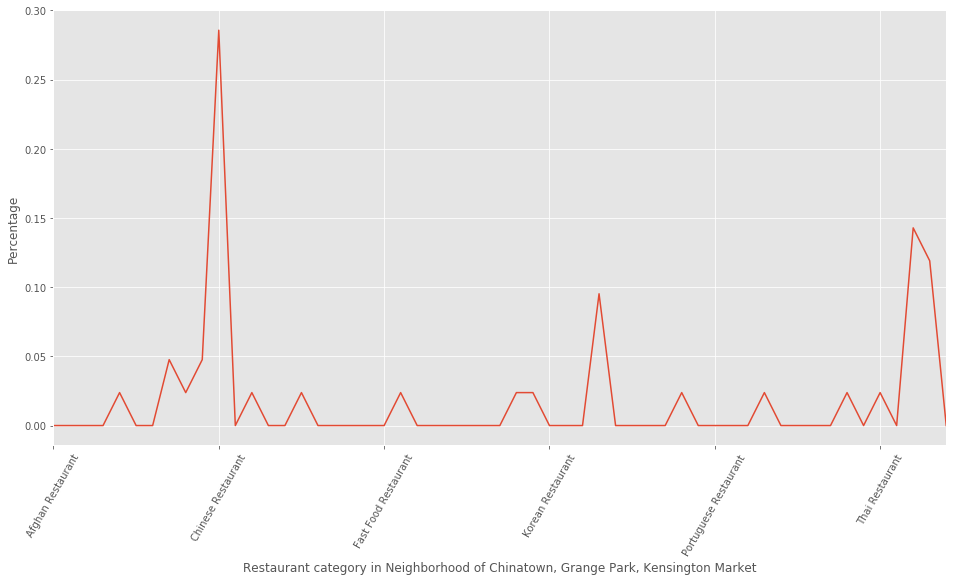

In [78]:
#Downtown_grouped.set_index("Neighborhood", inplace = True)
# plt.figure(figsize = (16,8))
# ax = Downtown_grouped.loc["Chinatown, Grange Park, Kensington Market"].plot()
# ax.set_xlabel("Restaurant category in Neighborhood of Chinatown, Grange Park, Kensington Market")
# ax.set_ylabel("Percentage")
# plt.xticks(rotation=60)

## Analytics-driven implications & Conculusions

Based on the empirical results, this section answers the following questions:
- Which neighborhood / Borough of Toronto is the best Choice for opening a new Chinese restaurant
- What are the other risks / opportunities to pay attention to, regarding this enterpreneurship adventure?
- TODOs in the following stage of research

### Conculusions

1. In The Borough "Downtown Toronto" of Toronto, there are 3 neighborhoods we can choose to open a new Chinese Restaurant, which are 
    - Adelaide, King, Richmond
    - Design Exchange, Toronto Dominion Centre
    - Church and Wellesley
1. Yet a series of other influencing factors need further discussions, for example
    - Demand side
        - Inhabitants and Tourists
            - Population structure, by age, income level, work, ethnity
        - Domestic consumer preferences regarding Chinese cuisine
    - Supply side
        - Competition situation
            - Major competitors' business, profitability situation
                - Potential responses to new entries
            - Supply chain
                - Materials
                - Chefs, Waiters/Waitresses
    - Market side   
        - Industry trend
        - Economy trend
        - Others...